# Machine Learning Task 2: binary classification

*Updated 8/25/24*

We start by loading all the required packages.

In [1]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import numpy as np
# reduce display precision on numpy arrays
np.set_printoptions(precision=1)
import pandas as pd
# reduce display precision on pandas dataframes
pd.set_option('display.precision', 1)
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import joblib

Load the example data file from GitHub first to check the codes. The collective memory about this catapult is stored in another file on GitHub. You can load that file later when you are ready to retrain the model with the most updated data.

The example data set ML_Catapult_ABC_sl.csv is a balanced dataset, with roughly equal frequency of 'short' and 'long' labels.  

The set ML_Catapult_ABC_sl2.csv has more labes of 'long'.

The set ML_Catapult_ABC_sl3.csv has more lables of 'short'.

In [2]:
#updated raw data url
#url='https://raw.githubusercontent.com/yanwu2001/DOE-ML-Public/main/PhysicalCatapult/Catapult_ABCDEFGy_raw.csv'
#example data for ML task1 polynomial regression
url='https://raw.githubusercontent.com/yanwu2001/DOE-ML-Public/main/PhysicalCatapult/ML_Catapult_ABC_sl.csv'
df=pd.read_csv(url)
print(df.head())
print(df.info())
print(df.describe())

     ID  Combo#  ball_mass  firing _height  band_length short_long
0  run1       0       61.3            18.0         41.8      short
1  run2       8       94.1            23.0         43.0      short
2  run3       3       22.9            23.0         40.6      short
3  run4       1       22.9            13.0         40.6       long
4  run5       2       22.9            13.0         43.0       long
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              100 non-null    object 
 1   Combo#          100 non-null    int64  
 2   ball_mass       100 non-null    float64
 3   firing _height  100 non-null    float64
 4   band_length     100 non-null    float64
 5   short_long      100 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 4.8+ KB
None
       Combo#  ball_mass  firing _height  band_length
count   100.0 

Define input data features and labels.

We also need to transform the text label into numbers. The Ordinal Encoder transforms text labels of 'short' and 'long' to 1 and 0.

Note: Label encoding is done outside the pipeline because it's applied to the target variable, not the features.


In [3]:
# separate the predictors and the labels
# get rid of unrelavent data
# define labels
ordinal_encoder = OrdinalEncoder()
y_data=ordinal_encoder.fit_transform(df[['short_long']])
y_data=pd.DataFrame(y_data,columns=['short_long'])
#original_data = ordinal_encoder.inverse_transform(y_data) to transform back
print(y_data.head())
print(y_data.describe())
X_data=df.drop(['ID','Combo#','short_long'],axis=1)
#impute missing values with the mean of the that attrubute,
# also available strategies: "median" "most_frequent"
imputer = SimpleImputer(strategy='mean')
X_data = imputer.fit_transform(X_data)

   short_long
0         1.0
1         1.0
2         1.0
3         0.0
4         0.0
       short_long
count       100.0
mean          0.5
std           0.5
min           0.0
25%           0.0
50%           1.0
75%           1.0
max           1.0


Splitting data into training, cross-validation, and test sets is a fundamental practice in machine learning to ensure that the models are robust, generalizable, and reliable. It prevents overfitting, provides unbiased performance evaluation, and ensures that the model can be trusted to perform well on new, unseen data.

In [4]:
# Split data
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
X_train, X_, y_train, y_ = train_test_split(X_data, y_data, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del X_, y_

print(f"the shape of the training set (input) is: {X_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {X_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {X_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")
print("the first 5 elements in X_train are :\n", X_train[:5])
print("the first 5 elements in y_train are :\n", y_train[:5])

the shape of the training set (input) is: (60, 3)
the shape of the training set (target) is: (60, 1)

the shape of the cross validation set (input) is: (20, 3)
the shape of the cross validation set (target) is: (20, 1)

the shape of the test set (input) is: (20, 3)
the shape of the test set (target) is: (20, 1)
the first 5 elements in X_train are :
     ball_mass  firing _height  band_length
86       68.5             7.4         47.3
53       94.1            19.0         42.0
77       22.9            14.2         33.0
15       22.9            13.0         43.0
83       61.3            10.4         39.5
the first 5 elements in y_train are :
     short_long
86         0.0
53         1.0
77         1.0
15         0.0
83         1.0



Maching learning algorithms do not work perform well when the input numerical attributes have very different scales. We will scale the input so that all data are roughly between -1 to 1. The same scaling rule need to apply for new data or during production in order for the model to work.


In [5]:

# Create a StandardScaler object for the training set, use the same scaling for all data
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X_train)
print(X.head())
#print(X.describe())
# never use fit() or fit_transform for anything else than the training set.
# to ensure other data use the same tranformer, use transform()

y=y_train.values.ravel()
print(y.shape)
print(y[0:5])

    ball_mass  firing _height  band_length
86        0.4            -1.4      9.9e-01
53        1.2             0.7     -5.9e-02
77       -1.1            -0.2     -1.8e+00
15       -1.1            -0.4      1.4e-01
83        0.1            -0.8     -5.5e-01
(60,)
[0. 1. 1. 0. 1.]


The LogisticRegression class in scikit-learn offers several solvers for optimization. Each solver has different properties and might be more suitable for certain datasets or problem types.

Here are the available solvers:

'lbfgs': Limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm. It's often a good choice for smaller datasets and can handle multinomial loss (multi-class problems).

'newton-cg': Newton's method with Conjugate Gradient. It's also suitable for smaller datasets and supports multinomial loss.
'liblinear': A library for large linear classification. It can handle both L1 and L2 regularization and works well for larger datasets.

'sag': Stochastic Average Gradient descent. Efficient for large datasets and supports L2 regularization.

'saga': A variant of 'sag' that also supports L1 regularization and elastic-net regularization.

In [6]:

# model=LogisticRegression().fit(X,y)
solvers = ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
# select one of the solvers and use max_iter forsetting iteration times
# the code below select lbfgs as the solver and set maximum iteration times to be 2000
model = LogisticRegression(solver=solvers[0], max_iter=2000)
# train the model, the default cut-off oor threshold value for losgiticregression is 0.5
model.fit(X, y)
print(model.coef_)
print(model.intercept_)


[[ 0.7  1.6 -2.1]]
[0.3]


Classification report on training set:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        26
         1.0       0.89      0.94      0.91        34

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.90        60
weighted avg       0.90      0.90      0.90        60

Confusion Matrix:
[[22  4]
 [ 2 32]]


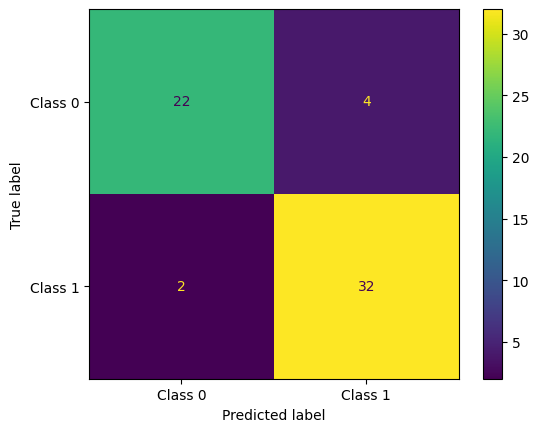

In [7]:
# Make predictions on the training data
y_pred = model.predict(X)
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X)[:, 1]

# Evaluate the model on training data (example: classification report)
report = classification_report(y, y_pred)
print("Classification report on training set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot()
plt.show()

True Positives (TP): The number of instances where the classifier correctly predicted the positive class.
False Positives (FP): The number of instances where the classifier incorrectly predicted the positive class (also known as Type I error).
False Negatives (FN): The number of instances where the classifier incorrectly predicted the negative class (also known as Type II error).
True Negatives (TN): The number of instances where the classifier correctly predicted the negative class.

[[TN FP]

[FN TP]]


In [8]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
y_pred_dummy = dummy_clf.predict(X)
report = classification_report(y, y_pred_dummy)
print("Classification report on training set using a dummy classifier:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred_dummy)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Classification report on training set using a dummy classifier:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        26
         1.0       0.57      1.00      0.72        34

    accuracy                           0.57        60
   macro avg       0.28      0.50      0.36        60
weighted avg       0.32      0.57      0.41        60

Confusion Matrix:
[[ 0 26]
 [ 0 34]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The DummyClassifier in scikit-learn provides several strategies for generating baseline predictions. These strategies determine how the dummy classifier makes predictions without considering the input features.

Using the stragety 'most_frequent', the DummyClassifer predicts the most frequent class in the training set. It is useful for establishing baseline performance and comparing the performance of your actual models against simple strategies.


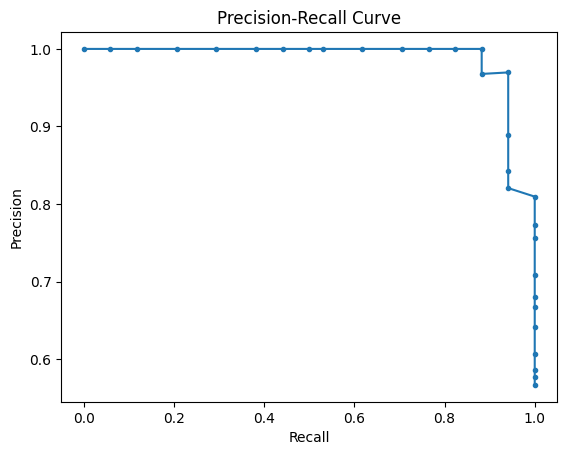

(0.0, 1.0)

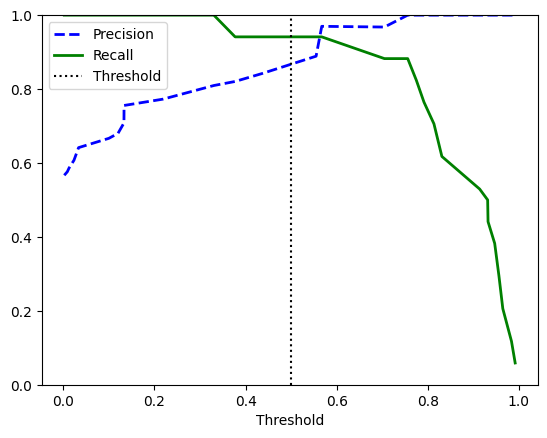

In [9]:
# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
#print(precision)
#print(recall)
#print(thresholds)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(0.5, 0.0, 1.0, "k", linestyle="dotted", label="Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])


The Precision-Recall (PR) curve is particularly useful for evaluating and selecting a threshold for classifiers when dealing with imbalanced datasets. The curve typically shows a trade-off between Precision and Recall. As you increase Recall, Precision usually decreases, and vice versa. An ideal classifier would have both high Precision and high Recall, resulting in a curve that hugs the top-right corner. If you need high Precision (minimizing false positives), select a threshold that corresponds to a point on the curve where Precision is high, even if Recall is lower.
If you need high Recall (minimizing false negatives), select a threshold where Recall is high, even if Precision is lower.
Suppose you are building a logistic regression model to classify fraudulent transactions. Since false positives (flagging a legitimate transaction as fraud) can be costly, you may prefer a threshold that maintains high Precision, even if it means missing some fraudulent transactions (lower Recall). By examining the PR curve, you can find a threshold that best meets this criterion.
One common way to select a threshold is to maximize the F1 score, which is the harmonic mean of Precision and Recall.
The threshold that maximizes the F1 score can be seen as a balanced trade-off between Precision and Recall.


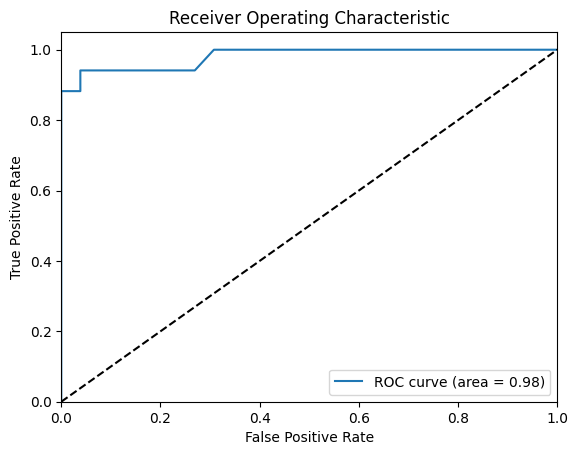

In [10]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a binary classifier. True Positive Rate (TPR, also known as Sensitivity or Recall) is the proportion of actual positives that are correctly identified by the classifier. False Positive Rate (FPR) is the proportion of actual negatives that are incorrectly identified as positives by the classifier. The ROC curve is plotted with the FPR on the x-axis and the TPR on the y-axis.
Each point on the ROC curve represents a different threshold that can be set to classify instances as positive or negative. By varying this threshold, you get different TPR and FPR values. A curve that hugs the top-left corner indicates a high TPR with a low FPR, which is desirable.
The most common way to evaluate the ROC curve is by calculating the Area Under the Curve (AUC). The AUC value ranges from 0 to 1:
AUC = 1: Perfect classifier.
AUC = 0.5: Classifier with no discrimination ability (random guessing).
AUC < 0.5: Worse than random guessing.

In [11]:
# Example: Using a threshold of 0.6
y_pred = (model.predict_proba(X)[:, 1] >= 0.6).astype(int)
# Evaluate the model on training data (example: classification report)
report = classification_report(y, y_pred)
print("Classification report on training set at threshold of 0.6:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)
# Print the confusion matrix
print("Confusion Matrix of training set at threshold of 0.6:")
print(cm)

Classification report on training set at threshold of 0.6:
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91        26
         1.0       0.97      0.88      0.92        34

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

Confusion Matrix of training set at threshold of 0.6:
[[25  1]
 [ 4 30]]


By default, scikit-learn's LogisticRegression uses a threshold of 0.5 to classify predictions. This means if the predicted probability of a sample belonging to the positive class is greater than or equal to 0.5, it's classified as positive, otherwise negative. If you want to change the threshold, you'll need to manually adjust it when making predictions, as in the example above.

In [12]:
# Make predictions on the cross validation data
X_scaled_cv = x_scaler.transform(X_cv)
y_pred = model.predict(X_scaled_cv)
# make prediction at cut-off/threshold =0.5
# Evaluate the model on validation data (example: classification report)
report = classification_report(y_cv, y_pred)
print("Classification report for validation set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_cv, y_pred)
# Print the confusion matrix
print("Confusion Matrix for validation set:")
print(cm)

Classification report for validation set:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92        13
         1.0       0.78      1.00      0.88         7

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix for validation set:
[[11  2]
 [ 0  7]]


In [13]:
#  Using a threshold of 0.6 for validation set
y_pred = (model.predict_proba(X_scaled_cv)[:, 1] >= 0.6).astype(int)
# Evaluate the model on training data (example: classification report)
report = classification_report(y_cv, y_pred)
print("Classification report on validation set at threshold of 0.6:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_cv, y_pred)
# Print the confusion matrix
print("Confusion Matrix of validation set at threshold of 0.6:")
print(cm)

Classification report on validation set at threshold of 0.6:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        13
         1.0       0.86      0.86      0.86         7

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20

Confusion Matrix of validation set at threshold of 0.6:
[[12  1]
 [ 1  6]]


Make pipeline of the model and check the output.  The code below trains a 1st order model and the output is the same as before for a threshold of 0.5.

In [14]:
preprocessing=make_pipeline(PolynomialFeatures(degree=1,include_bias=False),StandardScaler())
model=LogisticRegression(solver=solvers[0], max_iter=2000)
train_pipe=make_pipeline(preprocessing,model)
train_pipe.fit(X_train,y_train)
print("the fitting parameters for the 1st order model are:\n")
print("the weights are ", train_pipe[-1].coef_)
print("the intercept is", train_pipe[-1].intercept_)
y_pred_tr=train_pipe.predict(X_train)
report = classification_report(y_train, y_pred_tr)
print("Classification report on training set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred_tr)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

the fitting parameters for the 1st order model are:

the weights are  [[ 0.7  1.6 -2.1]]
the intercept is [0.3]
Classification report on training set:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        26
         1.0       0.89      0.94      0.91        34

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.90        60
weighted avg       0.90      0.90      0.90        60

Confusion Matrix:
[[22  4]
 [ 2 32]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Will a 2nd order model works better? We can use the following to check.

In [15]:
preprocessing=make_pipeline(PolynomialFeatures(degree=2,include_bias=False),StandardScaler(),OrdinalEncoder())
model=LogisticRegression(solver=solvers[0], max_iter=2000)
train_pipe=make_pipeline(preprocessing,model)
train_pipe.fit(X_train,y_train)
print("the fitting parameters for the 2nd order model are:\n")
print("the weights are ", train_pipe[-1].coef_)
print("the intercept is", train_pipe[-1].intercept_)
y_pred_tr=train_pipe.predict(X_train)
report = classification_report(y_train, y_pred_tr)
print("Classification report on training set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred_tr)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


the fitting parameters for the 2nd order model are:

the weights are  [[-0.1  0.8 -0.6 -0.1  0.6 -0.1  0.8 -0.7 -0.6]]
the intercept is [0.2]
Classification report on training set:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92        26
         1.0       0.89      1.00      0.94        34

    accuracy                           0.93        60
   macro avg       0.95      0.92      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
[[22  4]
 [ 0 34]]


In [16]:
y_pred_cv=train_pipe.predict(X_cv)
report = classification_report(y_cv, y_pred_cv)
print("Classification report for validation set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_cv, y_pred_cv)
# Print the confusion matrix
print("Confusion Matrix for validation set:")
print(cm)



Classification report for validation set:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92        13
         1.0       0.78      1.00      0.88         7

    accuracy                           0.90        20
   macro avg       0.89      0.92      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix for validation set:
[[11  2]
 [ 0  7]]


We can see the second order model does not enhance the model performance significantly.

In [17]:
# Select 1st order model as the final ML model
preprocessing=make_pipeline(PolynomialFeatures(degree=1,include_bias=False),StandardScaler())
model=LogisticRegression(solver=solvers[0], max_iter=2000)
train_pipe=make_pipeline(preprocessing,model)
train_pipe.fit(X_train,y_train)
y_pred_t=train_pipe.predict(X_test)
#print(y_pred_t)
#print(y_test)
report = classification_report(y_test, y_pred_t)
print("Classification report on test set:")
print(report)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_t)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)



Classification report on test set:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Confusion Matrix:
[[ 9  1]
 [ 0 10]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
joblib.dump(train_pipe, 'physical_catapult_classification.pkl')

['physical_catapult_classification.pkl']

In [19]:
final_model=joblib.load('physical_catapult_classification.pkl')
print("first 5 data points")
print(X_test.head())
print("the predicted class")
y_pred_t=final_model.predict(X_test)
y_pred=ordinal_encoder.inverse_transform(y_pred_t.reshape(-1,1))
y_test_t=ordinal_encoder.inverse_transform(y_test)
print(y_pred[0:5])
print("the actual class")
print(y_test_t[0:5])

first 5 data points
    ball_mass  firing _height  band_length
33       94.1             9.0         42.0
99       22.9            22.1         43.0
81       94.1             6.6         33.0
73       94.1             6.6         46.0
27       61.3            18.0         41.8
the predicted class
[['long']
 ['short']
 ['short']
 ['long']
 ['short']]
the actual class
[['long']
 ['short']
 ['short']
 ['long']
 ['short']]
